## Import Library & API

In [1]:
import pandas as pd
import pandas_ta as ta
from pandas.tseries.offsets import BusinessDay
import pandas_market_calendars as mcal
import pywt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL, ardl_select_order, UECM
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import fredapi as fa
from datetime import date
from twelvedata import TDClient
import vectorbt as vbt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import time
import re
import os

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ValueWarning)

os.chdir('/Users/fulinq/Documents/KMITL/FinancialEngineering/Y4/Y4T1/PROJECT/ARDL-ECM/Code/Gold/Finalized/V.1')

In [2]:
fred = fa.Fred(api_key='c948956426006ca126a2dd3bd1f07cee')
td = TDClient(apikey='aa61c51218c248698467af34d09b9d46')

## Data Retrieve ##

In [3]:
def fetch_fred(fred_client, series_id, col_name, percent = False, save_csv=False):
    df = fred_client.get_series(series_id)
    df.index = pd.to_datetime(df.index) 
    print(f'NaN value before processing: {df.isna().sum()}')
    df = df.ffill()
    print(f'NaN value after processing: {df.isna().sum()}')
    df.rename(col_name, inplace=True)
    print(f'Total records for {col_name}: {len(df)}')
    print(f'start date: {df.index.min()}')
    print(f'end date: {df.index.max()}')
    
    if percent:
        df = df.mul(0.01)
        print(f'Total records for {col_name} in percent: {len(df)}')
    
    if save_csv:
        filename = f"all_{col_name.lower()}_data_fred.csv"
        df.to_csv(filename)
        print(f"FRED data saved to {filename}")
    
    return pd.DataFrame(df)

def chow_lin_disaggregate(y_low: pd.Series, X_high: pd.DataFrame,
                          agg_method: str = 'sum', rho: float = None) -> tuple:
    y_low = y_low.dropna().copy()
    X_high = X_high.dropna().copy()
    n_high_per_low = 3  # Quarterly -> Monthly = 3 เดือนต่อไตรมาส

    # หาช่วงเวลาที่ซ้อนทับกัน (Overlapping period)
    quarters = y_low.index
    months = X_high.index
    min_date = max(quarters.min(), months.min().to_period('Q').to_timestamp())
    max_date = min(quarters.max(), months.max().to_period('Q').to_timestamp())

    y_low = y_low[(y_low.index >= min_date) & (y_low.index <= max_date)]
    
    # ปรับช่วงเวลาของ Monthly ให้ครอบคลุม Quarterly พอดี
    month_start = y_low.index.min()
    month_end = (y_low.index.max() + pd.offsets.QuarterEnd()).to_period('M').to_timestamp()
    X_high = X_high[(X_high.index >= month_start) & (X_high.index <= month_end)]

    n_low = len(y_low)
    n_high = n_low * n_high_per_low
    X_high = X_high.iloc[:n_high] # ตัดส่วนเกินออก

    # Build aggregation matrix C (Matrix สำหรับแปลงรายเดือนกลับเป็นไตรมาส)
    C = np.zeros((n_low, n_high))
    for i in range(n_low):
        start_col = i * n_high_per_low
        end_col = start_col + n_high_per_low
        if agg_method == 'sum': # สำหรับ Flow variable เช่น GDP
            C[i, start_col:end_col] = 1.0
        elif agg_method == 'mean': # สำหรับ Stock variable
            C[i, start_col:end_col] = 1.0 / n_high_per_low
        else:
            C[i, end_col - 1] = 1.0

    # Prepare X matrix
    X = X_high.values
    if X.ndim == 1: X = X.reshape(-1, 1)
    X = np.column_stack([np.ones(n_high), X]) # เพิ่ม Intercept

    # OLS เบื้องต้นเพื่อหาค่า Rho (Autocorrelation coefficient)
    X_low = C @ X
    y = y_low.values.flatten()
    beta_ols = np.linalg.lstsq(X_low, y, rcond=None)[0]
    u_low = y - X_low @ beta_ols

    if rho is None: # ถ้าไม่ได้กำหนดมา ให้คำนวณจาก Residuals
        if len(u_low) > 1:
            rho = np.corrcoef(u_low[:-1], u_low[1:])[0, 1]
            rho = np.clip(rho, -0.99, 0.99)
        else:
            rho = 0.0

    # GLS Estimation (พระเอกของงาน)
    # สร้าง Covariance Matrix V ตามโครงสร้าง AR(1)
    V = np.zeros((n_high, n_high))
    for i in range(n_high):
        for j in range(n_high):
            V[i, j] = rho ** abs(i - j)

    V_low = C @ V @ C.T
    try:
        V_low_inv = np.linalg.inv(V_low)
    except:
        V_low_inv = np.linalg.pinv(V_low)

    # คำนวณ Beta ด้วย GLS
    XVX = X_low.T @ V_low_inv @ X_low
    XVy = X_low.T @ V_low_inv @ y
    try:
        beta_gls = np.linalg.solve(XVX, XVy)
    except:
        beta_gls = np.linalg.lstsq(XVX, XVy, rcond=None)[0]

    # คำนวณค่าพยากรณ์และกระจาย Error (Distribute residuals)
    p_high = X @ beta_gls
    u_low_gls = y - X_low @ beta_gls
    VCt = V @ C.T
    
    try:
        dist_matrix = VCt @ np.linalg.inv(V_low)
    except:
        dist_matrix = VCt @ np.linalg.pinv(V_low)

    y_high = p_high + dist_matrix @ u_low_gls # ผลลัพธ์สุดท้าย

    result = pd.Series(y_high, index=X_high.index, name='GDP_Monthly_ChowLin')
    return result, beta_gls, rho

In [4]:
gold = vbt.YFData.download("GC=F", start="2006-01-01", interval="1d").get()
gold = pd.DataFrame(gold)
gold.columns = gold.columns.str.lower()
gold.index = pd.to_datetime(gold.index).tz_localize(None)
gold = gold.sort_index()
gold = gold.drop(columns=['dividends', 'stock splits'])
gold.to_csv('all_gold_data.csv')
gold = gold.get('close')
gold

Date
2006-01-03 05:00:00     530.700012
2006-01-04 05:00:00     533.900024
2006-01-05 05:00:00     526.299988
2006-01-06 05:00:00     539.700012
2006-01-09 05:00:00     549.099976
                          ...     
2026-02-12 05:00:00    4923.700195
2026-02-13 05:00:00    5022.000000
2026-02-17 05:00:00    4882.899902
2026-02-18 05:00:00    4986.500000
2026-02-19 05:00:00    5017.200195
Name: close, Length: 5063, dtype: float64

In [5]:
dollar_index = fetch_fred(fred, series_id='DTWEXBGS', col_name='Dollar Index')
dollar_index

NaN value before processing: 207
NaN value after processing: 0
Total records for Dollar Index: 5250
start date: 2006-01-02 00:00:00
end date: 2026-02-13 00:00:00


,Dollar Index
2006-01-02,101.4155
2006-01-03,100.7558
2006-01-04,100.2288
2006-01-05,100.2992
2006-01-06,100.0241
...,...
2026-02-09,117.6392
2026-02-10,117.5216
2026-02-11,117.4601
2026-02-12,117.5376


In [6]:
ppi = fetch_fred(fred, series_id='PPIACO', col_name='PPI')
ppi

NaN value before processing: 0
NaN value after processing: 0
Total records for PPI: 1356
start date: 1913-01-01 00:00:00
end date: 2025-12-01 00:00:00


,PPI
1913-01-01,12.100
1913-02-01,12.000
1913-03-01,12.000
1913-04-01,12.000
1913-05-01,11.900
...,...
2025-08-01,262.110
2025-09-01,262.094
2025-10-01,260.724
2025-11-01,261.358


In [7]:
fed_fund = fetch_fred(fred, series_id='FEDFUNDS', col_name='Federal Fund Rate', percent=True)
fed_fund

NaN value before processing: 0
NaN value after processing: 0
Total records for Federal Fund Rate: 859
start date: 1954-07-01 00:00:00
end date: 2026-01-01 00:00:00
Total records for Federal Fund Rate in percent: 859


,Federal Fund Rate
1954-07-01,0.0080
1954-08-01,0.0122
1954-09-01,0.0107
1954-10-01,0.0085
1954-11-01,0.0083
...,...
2025-09-01,0.0422
2025-10-01,0.0409
2025-11-01,0.0388
2025-12-01,0.0372


In [8]:
vix = fetch_fred(fred, series_id='VIXCLS', percent=True,col_name='VIX')
vix['VIX'] = vix['VIX'].mul(1 / np.sqrt(252))
vix

NaN value before processing: 301
NaN value after processing: 0
Total records for VIX: 9427
start date: 1990-01-02 00:00:00
end date: 2026-02-18 00:00:00
Total records for VIX in percent: 9427


,VIX
1990-01-02,0.010860
1990-01-03,0.011459
1990-01-04,0.012107
1990-01-05,0.012668
1990-01-08,0.012763
...,...
2026-02-12,0.013115
2026-02-13,0.012977
2026-02-16,0.013355
2026-02-17,0.012781


In [9]:
unemploy = fetch_fred(fred, series_id='ICSA', col_name='ISCA') #Initial Claims
unemploy

NaN value before processing: 0
NaN value after processing: 0
Total records for ISCA: 3085
start date: 1967-01-07 00:00:00
end date: 2026-02-14 00:00:00


,ISCA
1967-01-07,208000.0
1967-01-14,207000.0
1967-01-21,217000.0
1967-01-28,204000.0
1967-02-04,216000.0
...,...
2026-01-17,210000.0
2026-01-24,209000.0
2026-01-31,232000.0
2026-02-07,229000.0


In [10]:
ip = fetch_fred(fred, series_id='INDPRO', col_name='IP')
ip

NaN value before processing: 0
NaN value after processing: 0
Total records for IP: 1285
start date: 1919-01-01 00:00:00
end date: 2026-01-01 00:00:00


,IP
1919-01-01,4.8739
1919-02-01,4.6585
1919-03-01,4.5238
1919-04-01,4.6046
1919-05-01,4.6315
...,...
2025-09-01,101.7059
2025-10-01,101.2570
2025-11-01,101.3775
2025-12-01,101.6296


In [11]:
gdp = fetch_fred(fred, series_id='GDP', col_name='GDP')
gdp

NaN value before processing: 4
NaN value after processing: 4
Total records for GDP: 319
start date: 1946-01-01 00:00:00
end date: 2025-07-01 00:00:00


,GDP
1946-01-01,NaN
1946-04-01,NaN
1946-07-01,NaN
1946-10-01,NaN
1947-01-01,243.164
...,...
2024-07-01,29511.664
2024-10-01,29825.182
2025-01-01,30042.113
2025-04-01,30485.729


In [12]:
y_target = gdp['GDP']
X_indicator = ip[['IP']]

gdp_monthly_gls, beta, rho = chow_lin_disaggregate(y_low=y_target, X_high=X_indicator, agg_method='sum', rho=None)
print("Estimated Rho (Autocorrelation):", rho)
gdp = gdp_monthly_gls.copy()
gdp_monthly_gls

Estimated Rho (Autocorrelation): 0.99


1947-01-01       77.774623
1947-02-01       80.692609
1947-03-01       84.696768
1947-04-01       78.954071
1947-05-01       82.894270
                  ...     
2025-05-01    10144.515129
2025-06-01    10243.720934
2025-07-01    10350.652186
2025-08-01    10374.011335
2025-09-01    10373.363479
Name: GDP_Monthly_ChowLin, Length: 945, dtype: float64

In [13]:
fed_balance = fetch_fred(fred, series_id='WALCL', col_name='Fed Balance Sheet') #Federal Reserve Total Assets
fed_balance

NaN value before processing: 0
NaN value after processing: 0
Total records for Fed Balance Sheet: 1210
start date: 2002-12-18 00:00:00
end date: 2026-02-18 00:00:00


,Fed Balance Sheet
2002-12-18,719542.0
2002-12-25,732059.0
2003-01-01,730994.0
2003-01-08,723762.0
2003-01-15,720074.0
...,...
2026-01-21,6584580.0
2026-01-28,6587568.0
2026-02-04,6605909.0
2026-02-11,6622382.0


In [14]:
# 1. organize data
realtime_data = {
    'gold': gold,
    'dollar_index': dollar_index,
    'vix': vix,
    'fed_rate': fed_fund,
    'fed_balance': fed_balance,
    'labor_claims': unemploy
}

lagged_data = {
    'ip': ip,
    'gdp': gdp,
    'ppi': ppi
}

# 2. resample & rename
monthly_dfs = []

# process real-time
for name, data in realtime_data.items():
    # FIX: force rename for both Series and DataFrame to match the key (lowercase)
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    
    if name in ['labor_claims', 'vix']:
        monthly_dfs.append(data.resample('ME').mean())
    else:
        monthly_dfs.append(data.resample('ME').last())

# process lagged
for name, data in lagged_data.items():
    if isinstance(data, pd.DataFrame):
        data = data.iloc[:, 0].to_frame(name)
    else:
        data = data.to_frame(name)
    monthly_dfs.append(data.resample('ME').last())

# 3. merge
df_final = pd.concat(monthly_dfs, axis=1)

# 4. handle lag (shift)
vars_to_shift = ['ip', 'ppi']
for col in vars_to_shift:
    df_final[col] = df_final[col].shift(1)
df_final['gdp'] = df_final['gdp'].shift(4)

# 5. target variable
df_final['target_gold'] = df_final['gold'].shift(-1)

# 6. feature selection
features = [
    'gold', 'dollar_index', 'vix', 'fed_rate', 
    'fed_balance', 'labor_claims', 
    'ip', 'gdp','ppi'
]

df_model = df_final[features + ['target_gold']].dropna()

# check
print(f"data range: {df_model.index.min().date()} to {df_model.index.max().date()}")
print(df_model.columns)
df_model

data range: 2006-01-31 to 2026-01-31
Index(['gold', 'dollar_index', 'vix', 'fed_rate', 'fed_balance',
       'labor_claims', 'ip', 'gdp', 'ppi', 'target_gold'],
      dtype='object')


,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,gdp,ppi,target_gold
2006-01-31,570.799988,99.4311,0.007560,0.0429,828901.0,295750.0,98.0452,4330.641421,163.000,561.599976
2006-02-28,561.599976,99.7695,0.007842,0.0449,840555.0,290750.0,98.1999,4387.341134,164.300,581.799988
2006-03-31,581.799988,100.5600,0.007366,0.0459,833675.0,301750.0,98.2413,4449.366137,161.800,651.799988
2006-04-30,651.799988,98.1412,0.007480,0.0479,844572.0,303600.0,98.4628,4487.496729,162.200,642.500000
2006-05-31,642.500000,97.7705,0.009100,0.0494,851580.0,332750.0,98.7618,4515.040605,164.300,613.500000
...,...,...,...,...,...,...,...,...,...,...
2025-09-30,3840.800049,120.1368,0.009946,0.0422,6608395.0,234750.0,101.6247,10144.515129,262.110,3982.199951
2025-10-31,3982.199951,121.3859,0.011393,0.0409,6587034.0,226750.0,101.7059,10243.720934,262.094,4218.299805
2025-11-30,4218.299805,121.0527,0.012454,0.0388,6552419.0,217600.0,101.2570,10350.652186,260.724,4325.600098
2025-12-31,4325.600098,119.7456,0.009738,0.0372,6640618.0,219000.0,101.3775,10374.011335,261.358,4713.899902


In [15]:
df_model.to_csv('gold_price_model_data.csv')

In [16]:
df_ret = pd.DataFrame()
cols_to_transform = ['gold', 'gdp', 'ip', 'ppi','dollar_index', 'labor_claims', 'fed_balance'] # ไม่เอา IP, PPI ตามแผน Core Model
cols_not_to_transform = ['fed_rate', 'vix'] # ตัวแปรที่ไม่ทำ log return
for col in cols_to_transform:
    if col in df_model.columns:
        df_ret[f'{col}_ret'] = np.log(df_model[col]).diff()
for col in cols_not_to_transform:
    if col in df_model.columns:
        df_ret[f'{col}_change'] = df_model[col].diff()
    
df_ret.dropna(inplace=True)
df_ret

,gold_ret,gdp_ret,ip_ret,ppi_ret,dollar_index_ret,labor_claims_ret,fed_balance_ret,fed_rate_change,vix_change
2006-02-28,-0.016249,0.013008,0.001577,0.007944,0.003398,-0.017051,0.013962,0.0020,0.000282
2006-03-31,0.035337,0.014038,0.000422,-0.015333,0.007892,0.037135,-0.008219,0.0010,-0.000475
2006-04-30,0.113611,0.008533,0.002252,0.002469,-0.024347,0.006112,0.012986,0.0020,0.000113
2006-05-31,-0.014371,0.006119,0.003032,0.012864,-0.003784,0.091680,0.008263,0.0015,0.001620
2006-06-30,-0.046187,0.003576,0.000254,0.009088,0.004875,-0.085442,-0.008424,0.0005,0.001558
...,...,...,...,...,...,...,...,...,...
2025-09-30,0.100460,0.004646,-0.002646,-0.000946,-0.000594,0.020442,0.000759,-0.0011,0.000025
2025-10-31,0.036154,0.009732,0.000799,-0.000061,0.010344,-0.034673,-0.003238,-0.0013,0.001447
2025-11-30,0.057598,0.010385,-0.004423,-0.005241,-0.002749,-0.041190,-0.005269,-0.0021,0.001060
2025-12-31,0.025119,0.002254,0.001189,0.002429,-0.010856,0.006413,0.013371,-0.0016,-0.002716


## Data Preparation ##

In [17]:
df_model = pd.read_csv('gold_price_model_data.csv', index_col=0, parse_dates=True)
df_model

,gold,dollar_index,vix,fed_rate,fed_balance,labor_claims,ip,gdp,ppi,target_gold
2006-01-31,570.799988,99.4311,0.007560,0.0429,828901.0,295750.0,98.0452,4330.641421,163.000,561.599976
2006-02-28,561.599976,99.7695,0.007842,0.0449,840555.0,290750.0,98.1999,4387.341134,164.300,581.799988
2006-03-31,581.799988,100.5600,0.007366,0.0459,833675.0,301750.0,98.2413,4449.366137,161.800,651.799988
2006-04-30,651.799988,98.1412,0.007480,0.0479,844572.0,303600.0,98.4628,4487.496729,162.200,642.500000
2006-05-31,642.500000,97.7705,0.009100,0.0494,851580.0,332750.0,98.7618,4515.040605,164.300,613.500000
...,...,...,...,...,...,...,...,...,...,...
2025-09-30,3840.800049,120.1368,0.009946,0.0422,6608395.0,234750.0,101.6247,10144.515129,262.110,3982.199951
2025-10-31,3982.199951,121.3859,0.011393,0.0409,6587034.0,226750.0,101.7059,10243.720934,262.094,4218.299805
2025-11-30,4218.299805,121.0527,0.012454,0.0388,6552419.0,217600.0,101.2570,10350.652186,260.724,4325.600098
2025-12-31,4325.600098,119.7456,0.009738,0.0372,6640618.0,219000.0,101.3775,10374.011335,261.358,4713.899902


In [18]:
vars_to_log = ['gold', 'dollar_index', 'fed_balance', 'labor_claims', 'ip', 'gdp','ppi', 'target_gold']
for col in vars_to_log:
    df_model[f'ln_{col}'] = np.log(df_model[col])

model_vars = ['fed_rate', 'vix'] + [f'ln_{c}' for c in vars_to_log]
df_ardl = df_model[model_vars].dropna()

df_ardl

,fed_rate,vix,ln_gold,ln_dollar_index,ln_fed_balance,ln_labor_claims,ln_ip,ln_gdp,ln_ppi,ln_target_gold
2006-01-31,0.0429,0.007560,6.347039,4.599465,13.627856,12.597270,4.585429,8.373471,5.093750,6.330790
2006-02-28,0.0449,0.007842,6.330790,4.602863,13.641818,12.580219,4.587005,8.386479,5.101694,6.366127
2006-03-31,0.0459,0.007366,6.366127,4.610755,13.633599,12.617354,4.587427,8.400517,5.086361,6.479738
2006-04-30,0.0479,0.007480,6.479738,4.586407,13.646585,12.623466,4.589679,8.409050,5.088830,6.465367
2006-05-31,0.0494,0.009100,6.465367,4.582623,13.654849,12.715147,4.592711,8.415169,5.101694,6.419180
...,...,...,...,...,...,...,...,...,...,...
2025-09-30,0.0422,0.009946,8.253436,4.788631,15.703851,12.366276,4.621287,9.224688,5.568764,8.289590
2025-10-31,0.0409,0.011393,8.289590,4.798975,15.700614,12.331603,4.622085,9.234420,5.568703,8.347187
2025-11-30,0.0388,0.012454,8.347187,4.796226,15.695345,12.290414,4.617662,9.244805,5.563462,8.372306
2025-12-31,0.0372,0.009738,8.372306,4.785369,15.708716,12.296827,4.618851,9.247059,5.565891,8.458271


In [19]:
def run_adf_test(series, name):
    # Test at Level
    result = adfuller(series.dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        return f"I(0) - Stationary (p={p_value:.4f})"
    else:
        # ถ้า Level ไม่นิ่ง ให้ลอง Test แบบ Diff (First Difference)
        diff_result = adfuller(series.diff().dropna())
        diff_p_value = diff_result[1]
        
        if diff_p_value <= 0.05:
            return f"I(1) - Stationary at Diff (p={diff_p_value:.4f})"
        else:
            return f"I(2) or Higher (Non-Stationary) (p={diff_p_value:.4f})"
        
summary_data = []
for col in df_ardl.columns:
    status = run_adf_test(df_ardl[col], col)
    summary_data.append({'Variable': col, 'Status': status})

df_status = pd.DataFrame(summary_data)
df_status

,Variable,Status
0,fed_rate,I(1) - Stationary at Diff (p=0.0050)
1,vix,I(0) - Stationary (p=0.0008)
2,ln_gold,I(1) - Stationary at Diff (p=0.0000)
3,ln_dollar_index,I(1) - Stationary at Diff (p=0.0000)
4,ln_fed_balance,I(1) - Stationary at Diff (p=0.0000)
5,ln_labor_claims,I(0) - Stationary (p=0.0182)
6,ln_ip,I(1) - Stationary at Diff (p=0.0000)
7,ln_gdp,I(1) - Stationary at Diff (p=0.0000)
8,ln_ppi,I(1) - Stationary at Diff (p=0.0000)
9,ln_target_gold,I(1) - Stationary at Diff (p=0.0000)


In [20]:
X_cols = ['fed_rate'
          ,'ln_gold'
          ,'ln_dollar_index'
          ,'vix'
          ,'ln_labor_claims'
          ,'ln_ip'
        #   ,'ln_gdp'
          ,'ln_ppi'
        #   ,'ln_fed_balance'
          ]

X = df_ardl[X_cols].dropna()
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,Variable,VIF
0,const,29112.077053
1,fed_rate,1.445183
2,ln_gold,5.108960
3,ln_dollar_index,1.824137
4,vix,1.743549
5,ln_labor_claims,2.576206
6,ln_ip,1.997837
7,ln_ppi,6.169819


In [21]:
train_date_str = '2015-12-31'
df_test_ardl = df_ardl[df_ardl.index <= train_date_str].copy()
df_test_ardl

,fed_rate,vix,ln_gold,ln_dollar_index,ln_fed_balance,ln_labor_claims,ln_ip,ln_gdp,ln_ppi,ln_target_gold
2006-01-31,0.0429,0.007560,6.347039,4.599465,13.627856,12.597270,4.585429,8.373471,5.093750,6.330790
2006-02-28,0.0449,0.007842,6.330790,4.602863,13.641818,12.580219,4.587005,8.386479,5.101694,6.366127
2006-03-31,0.0459,0.007366,6.366127,4.610755,13.633599,12.617354,4.587427,8.400517,5.086361,6.479738
2006-04-30,0.0479,0.007480,6.479738,4.586407,13.646585,12.623466,4.589679,8.409050,5.088830,6.465367
2006-05-31,0.0494,0.009100,6.465367,4.582623,13.654849,12.715147,4.592711,8.415169,5.101694,6.419180
...,...,...,...,...,...,...,...,...,...,...
2015-08-31,0.0014,0.012239,7.031388,4.705577,15.314040,12.525253,4.617324,8.713265,5.267343,7.017058
2015-09-30,0.0014,0.015454,7.017058,4.712509,15.316051,12.504324,4.615484,8.715785,5.256974,7.040098
2015-10-31,0.0012,0.010576,7.040098,4.702369,15.317216,12.495004,4.612689,8.715764,5.242276,6.971481
2015-11-30,0.0012,0.010181,6.971481,4.721530,15.314483,12.500606,4.607842,8.721109,5.233779,6.966307


In [22]:
y_col = 'ln_gold'
X_cols = ['fed_rate'
          ,'ln_dollar_index'
        #   ,'vix'
          # ,'ln_labor_claims'
        #   ,'ln_ip'
        #   ,'ln_gdp'
          # ,'ln_ppi'
          # ,'ln_fed_balance'
          ]

data_ardl = df_test_ardl[[y_col] + X_cols].dropna()

custom_max_order = {
    'fed_rate': 6,
    'ln_dollar_index': 6,
    # 'vix': 3,
    # 'ln_labor_claims': 6,
    # 'ln_ip': 3,
    # 'ln_ppi': 6
}

sel_res = ardl_select_order(
    data_ardl[y_col], 
    maxlag=6, 
    exog=data_ardl[X_cols], 
    maxorder=custom_max_order,
    ic='aic'
)

print(f"Best AR Lags: {sel_res.ar_lags}")
print(f"Best DL Orders: {sel_res.dl_lags}")

Best AR Lags: [1, 2]
Best DL Orders: {'fed_rate': [0], 'ln_dollar_index': [0, 1]}


In [23]:
ar_lag = max(sel_res.ar_lags) if isinstance(sel_res.ar_lags, list) else sel_res.ar_lags
dl_lags = {k: (max(v) if isinstance(v, list) else v) for k, v in sel_res.dl_lags.items()}
exog_order = {}
for i in dl_lags:
    exog_order[i] = max(1, dl_lags[i])
    
print(f"\n--- 2. ARDL Levels Analysis & Bounds Test ---")
model_ardl = ARDL(
    data_ardl[y_col], 
    lags=ar_lag, 
    exog=data_ardl[X_cols], 
    order=exog_order
)
res_ardl = model_ardl.fit()
res_ardl.summary()


--- 2. ARDL Levels Analysis & Bounds Test ---


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                ln_gold   No. Observations:                  120
Model:                  ARDL(2, 1, 1)   Log Likelihood                 192.616
Method:               Conditional MLE   S.D. of innovations              0.047
Date:                Fri, 20 Feb 2026   AIC                           -369.232
Time:                        11:57:27   BIC                           -347.067
Sample:                    03-31-2006   HQIC                          -360.232
                         - 12-31-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.4909      0.578      2.578      0.011       0.345       2.637
ln_gold.L1             0.7783      0.085      9.116      0.000       0.609       0.948
ln_gold.L2             0.1301      0.081      1.598      0.113      -0.031       0.291
fed_rate.L0            1.4713      3.160      0.466      0.642      -4.791       7.733
fed_rate.L1           -2.5624      3.227     -0.794      0.429      -8.957       3.832
ln_dollar_index.L0    -1.3281      0.246     -5.406      0.000      -1.815      -0.841
ln_dollar_index.L1     1.1461      0.263      4.354      0.000       0.625       1.668
======================================================================================
"""

In [24]:
model_uecm = UECM(
    data_ardl[y_col], 
    lags=6, 
    exog=data_ardl[X_cols], 
    order=exog_order
)
res_uecm = model_uecm.fit()

# 2. รัน Bounds Test จากผลลัพธ์ของ UECM
# case 3 คือมี intercept แต่ไม่มี trend (นิยมใช้ที่สุด)
bt_results = res_uecm.bounds_test(case=3)

print("--- ARDL Bounds Test Results ---")
print(bt_results)

# 3. ดูค่า ECT (ในตาราง summary จะชื่อประมาณ 'diff.ln_gold.L1' หรือตัวแปรที่เป็นระดับ Level)
# หรือดูค่า Adjustment Term โดยตรง
print("\n--- UECM Summary (ดูค่า ECT และนัยสำคัญ) ---")
print(res_uecm.summary())

--- ARDL Bounds Test Results ---
BoundsTestResult
Stat: 2.97326
Upper P-value: 0.232
Lower P-value: 0.0716
Null: No Cointegration
Alternative: Possible Cointegration


--- UECM Summary (ดูค่า ECT และนัยสำคัญ) ---
                              UECM Model Results                              
Dep. Variable:              D.ln_gold   No. Observations:                  120
Model:                  UECM(6, 1, 1)   Log Likelihood                 187.410
Method:               Conditional MLE   S.D. of innovations              7.028
Date:                Fri, 20 Feb 2026   AIC                           -350.820
Time:                        11:57:27   BIC                           -317.985
Sample:                    07-31-2006   HQIC                          -337.494
                         - 12-31-2015                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

## ARDL-ECM Forcast

In [25]:
exog_order_pure = {}
for i in exog_order:
    exog_order_pure[i] = [int(j) for j in range(1, exog_order[i]+1)]
ar_order = ar_lag

train_data = df_test_ardl.copy()
test_data = df_ardl[df_ardl.index > train_date_str].copy()

history = train_data.copy()
predictions = []
actuals = test_data[y_col].values

print(f"Train Period: {train_data.index[0].date()} to {train_data.index[-1].date()} (Count: {len(train_data)})")
print(f"Test Period:  {test_data.index[0].date()} to {test_data.index[-1].date()} (Count: {len(test_data)})")
print(f"\nStarting Walk-Forward Forecast (OOS)")

for t in range(len(test_data)):
    model = ARDL(
        endog=history[y_col],
        lags=ar_order,
        exog=history[X_cols],
        order=exog_order_pure,
        trend='c'
    )
    model_fit = model.fit()
    
    next_exog = test_data.iloc[[t]][X_cols]
    
    pred = model_fit.predict(start=len(history), end=len(history), exog_oos=next_exog)
    yhat = pred.values[0]
    predictions.append(yhat)
    
    history = pd.concat([history, test_data.iloc[[t]]])
    
    # warking forward
    # history = history.iloc[1:]
    
    if (t+1) % 12 == 0:
        print(f"Step {t+1}: {test_data.index[t].date()} -> Pred={np.exp(yhat):.4f} | Actual={np.exp(actuals[t]):.4f}")

final_model = ARDL(endog=history[y_col], lags=ar_order, exog=history[X_cols], order=exog_order_pure, trend='c')
final_model_fit = final_model.fit()
next_exog_future = history.iloc[[-1]][X_cols]
pred_future = final_model_fit.predict(start=len(history), end=len(history), exog_oos=next_exog_future)
yhat_future = pred_future.values[0]
# predictions.append(yhat_future)

actual_price = np.exp(actuals)
pred_price = np.exp(predictions)

results = pd.DataFrame({
    'Actual': actuals,
    'Predicted' : predictions,
    'Error' : actuals - predictions,
    'Actual_Price': actual_price,
    'Predicted_Price': pred_price,
    'Error_Price' : actual_price - pred_price
}, index=test_data.index)
last_date = results.index[-1]
next_date = last_date + BusinessDay(n=1)
future_row = pd.DataFrame({
    'Actual': [np.nan],              
    'Predicted': [yhat_future],      
    'Error': [np.nan],               
    'Actual_Price': [np.nan],        
    'Predicted_Price': [np.exp(yhat_future)], 
    'Error_Price': [np.nan]  
}, index=[next_date]) 

results = pd.concat([results, future_row])       
results.round(2)

Train Period: 2006-01-31 to 2015-12-31 (Count: 120)
Test Period:  2016-01-31 to 2026-01-31 (Count: 121)

Starting Walk-Forward Forecast (OOS)
Step 12: 2016-12-31 -> Pred=1180.0715 | Actual=1150.0000
Step 24: 2017-12-31 -> Pred=1265.9359 | Actual=1306.3000
Step 36: 2018-12-31 -> Pred=1208.7312 | Actual=1278.3000
Step 48: 2019-12-31 -> Pred=1466.0750 | Actual=1519.5000
Step 60: 2020-12-31 -> Pred=1782.2872 | Actual=1893.1000
Step 72: 2021-12-31 -> Pred=1774.5937 | Actual=1827.5000
Step 84: 2022-12-31 -> Pred=1721.5185 | Actual=1819.7000
Step 96: 2023-12-31 -> Pred=2030.8822 | Actual=2062.3999
Step 108: 2024-12-31 -> Pred=2686.3408 | Actual=2629.2000
Step 120: 2025-12-31 -> Pred=4253.3434 | Actual=4325.6001


,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
2016-01-31,7.02,6.96,0.06,1116.4,1051.75,64.65
2016-02-29,7.12,7.00,0.12,1233.9,1095.09,138.81
2016-03-31,7.12,7.10,0.02,1234.2,1209.70,24.50
2016-04-30,7.16,7.12,0.05,1289.2,1231.01,58.19
2016-05-31,7.10,7.15,-0.05,1214.8,1278.68,-63.88
...,...,...,...,...,...,...
2025-10-31,8.29,8.25,0.03,3982.2,3846.57,135.63
2025-11-30,8.35,8.30,0.05,4218.3,4018.91,199.39
2025-12-31,8.37,8.36,0.02,4325.6,4253.34,72.26
2026-01-31,8.46,8.38,0.07,4713.9,4373.48,340.42


In [26]:
rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
mae = mean_absolute_error(actual_price, pred_price)

print(f"RMSE (USD): {rmse:.2f}")
print(f"MAE (USD):  {mae:.2f}")

RMSE (USD): 88.79
MAE (USD):  64.15


In [27]:
# plt.figure(figsize=(14, 7))

# plt.axvline(x=pd.to_datetime('2015-12-31'), color='gray', linestyle=':', label='Train/Test Split')

# plt.plot(df_ardl.index, np.exp(df_ardl[y_col]), label='Actual History', color='lightgray')
# plt.plot(test_data.index, actual_price, label='Actual Test Data', color='#1f77b4', linewidth=2)
# plt.plot(test_data.index, pred_price, label='Forecast (Pure OOS)', color='#d62728', linestyle='--', linewidth=2)

# plt.title('Gold Price Forecast: Out-of-Sample Testing (2016-Present)')
# plt.xlabel('Date')
# plt.ylabel('Price (USD)')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_ardl.index, 
    y=np.exp(df_ardl[y_col]),
    mode='lines',
    name='Actual History',
    line=dict(color='lightgray')
))

fig.add_trace(go.Scatter(
    x=test_data.index, 
    y=actual_price,
    mode='lines',
    name='Actual Test (2016-Present)',
    line=dict(color='#1f77b4', width=2)
))

fig.add_trace(go.Scatter(
    x=test_data.index, 
    y=pred_price,
    mode='lines',
    name='Forecast',
    line=dict(color='#d62728', width=2, dash='dash')
))

fig.update_layout(
    width=1000,
    height=700,
    autosize=False,
    title='Gold Price Forecast: Interactive Walk-Forward Validation',
    yaxis_title='Price (USD)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    template="plotly_white",
    legend=dict(x=0, y=1)
)

fig.show()

In [29]:
exog_order_pure = {}
for i in exog_order:
    exog_order_pure[i] = [int(j) for j in range(1, exog_order[i]+1)]
ar_order = ar_lag

# --- 1. Define Stationary and Non-Stationary Variables ---
# Based on your ADF test results
i0_vars = ['vix', 'ln_labor_claims'] 
i1_vars = [col for col in df_ardl.columns if col not in i0_vars]

# --- 2. Create a Stationary DataFrame for ARDL modeling ---
df_stat = df_ardl.copy()
df_stat[i1_vars] = df_stat[i1_vars].diff() # Apply First Difference to I(1) variables ONLY
df_stat = df_stat.dropna() # Drop the first row containing NaNs from differencing

# --- 3. Split Data into Train and Test ---
# 'stat' is used for model training/predicting (differences)
train_data_stat = df_stat[df_stat.index <= train_date_str].copy()
test_data_stat  = df_stat[df_stat.index > train_date_str].copy()

# 'level' is kept for price reconstruction later
history_level = df_ardl[df_ardl.index <= train_date_str].copy()
test_data_level = df_ardl[df_ardl.index > train_date_str].copy()

history_stat = train_data_stat.copy()

predictions_diff = []
predictions_log_level = []
actuals_log_level = test_data_level[y_col].values

print(f"Train Period: {train_data_stat.index[0].date()} to {train_data_stat.index[-1].date()} (Count: {len(train_data_stat)})")
print(f"Test Period:  {test_data_stat.index[0].date()} to {test_data_stat.index[-1].date()} (Count: {len(test_data_stat)})")
print(f"\nStarting Walk-Forward Forecast (Stationary OOS)")

# --- 4. Walk-Forward Loop ---
for t in range(len(test_data_stat)):
    
    # Fit ARDL on Stationary Data
    model = ARDL(
        endog=history_stat[y_col],
        lags=ar_order,
        exog=history_stat[X_cols],
        order=exog_order_pure,
        trend='c'
    )
    model_fit = model.fit()
    
    # Predict the next difference (Return)
    next_exog = test_data_stat.iloc[[t]][X_cols]
    pred_diff = model_fit.predict(start=len(history_stat), end=len(history_stat), exog_oos=next_exog).values[0]
    
    # Reconstruct Log Level: Previous Actual Log Level + Predicted Difference
    prev_actual_log_level = history_level[y_col].iloc[-1]
    yhat_log_level = prev_actual_log_level + pred_diff
    
    predictions_diff.append(pred_diff)
    predictions_log_level.append(yhat_log_level)
    
    # Update histories with the new actual row
    history_stat = pd.concat([history_stat, test_data_stat.iloc[[t]]])
    history_level = pd.concat([history_level, test_data_level.iloc[[t]]])
    
    if (t+1) % 12 == 0:
        print(f"Step {t+1}: {test_data_stat.index[t].date()} -> Pred Price={np.exp(yhat_log_level):.2f} | Actual Price={np.exp(actuals_log_level[t]):.2f}")

# --- 5. Predict the Future (T+1) ---
final_model = ARDL(
    endog=history_stat[y_col], 
    lags=ar_order, 
    exog=history_stat[X_cols], 
    order=exog_order_pure, 
    trend='c'
)
final_model_fit = final_model.fit()

# Use the last known exog values (Naive approach) for future prediction
next_exog_future = history_stat.iloc[[-1]][X_cols] 
pred_diff_future = final_model_fit.predict(start=len(history_stat), end=len(history_stat), exog_oos=next_exog_future).values[0]

# Reconstruct future price
prev_actual_log_level_future = history_level[y_col].iloc[-1]
yhat_log_level_future = prev_actual_log_level_future + pred_diff_future

# --- 6. Assemble the Final Results DataFrame & Apply mcal ---
actual_price = np.exp(actuals_log_level)
pred_price = np.exp(predictions_log_level)

results = pd.DataFrame({
    'Actual': actuals_log_level,
    'Predicted' : predictions_log_level,
    'Error' : actuals_log_level - predictions_log_level,
    'Actual_Price': actual_price,
    'Predicted_Price': pred_price,
    'Error_Price' : actual_price - pred_price
}, index=test_data_stat.index)

last_date = results.index[-1]

# Use mcal to find the exact next CME Gold trading day
market_cal = mcal.get_calendar('CMEGlobex_Gold')
start_search = last_date + pd.Timedelta(days=1)
end_search = start_search + pd.Timedelta(days=15) # Buffer for long holidays

# Get the exact next valid trading day
valid_days = market_cal.valid_days(start_date=start_search, end_date=end_search)
next_date = valid_days[0].tz_localize(None) # Remove timezone for clean index

# Append the future prediction row
future_row = pd.DataFrame({
    'Actual': [np.nan],              
    'Predicted': [yhat_log_level_future],                    
    'Actual_Price': [np.nan],        
    'Predicted_Price': [np.exp(yhat_log_level_future)], 
    'Error': [np.nan],
    'Error_Price': [np.nan]  
}, index=[next_date]) 

results = pd.concat([results, future_row])       

print("\nFinal Results (with exact CME Trading Dates):")
results.round(2)

Train Period: 2006-02-28 to 2015-12-31 (Count: 119)
Test Period:  2016-01-31 to 2026-01-31 (Count: 121)

Starting Walk-Forward Forecast (Stationary OOS)
Step 12: 2016-12-31 -> Pred Price=1192.31 | Actual Price=1150.00
Step 24: 2017-12-31 -> Pred Price=1281.06 | Actual Price=1306.30
Step 36: 2018-12-31 -> Pred Price=1223.98 | Actual Price=1278.30
Step 48: 2019-12-31 -> Pred Price=1492.09 | Actual Price=1519.50
Step 60: 2020-12-31 -> Pred Price=1800.78 | Actual Price=1893.10
Step 72: 2021-12-31 -> Pred Price=1781.76 | Actual Price=1827.50
Step 84: 2022-12-31 -> Pred Price=1698.27 | Actual Price=1819.70
Step 96: 2023-12-31 -> Pred Price=2045.79 | Actual Price=2062.40
Step 108: 2024-12-31 -> Pred Price=2696.57 | Actual Price=2629.20
Step 120: 2025-12-31 -> Pred Price=4260.68 | Actual Price=4325.60

Final Results (with exact CME Trading Dates):


,Actual,Predicted,Error,Actual_Price,Predicted_Price,Error_Price
2016-01-31,7.02,6.97,0.05,1116.4,1062.07,54.33
2016-02-29,7.12,7.01,0.11,1233.9,1105.12,128.78
2016-03-31,7.12,7.10,0.01,1234.2,1217.30,16.90
2016-04-30,7.16,7.12,0.04,1289.2,1235.16,54.04
2016-05-31,7.10,7.16,-0.06,1214.8,1289.11,-74.31
...,...,...,...,...,...,...
2025-10-31,8.29,8.25,0.04,3982.2,3839.60,142.60
2025-11-30,8.35,8.29,0.05,4218.3,4003.21,215.09
2025-12-31,8.37,8.36,0.02,4325.6,4260.68,64.92
2026-01-31,8.46,8.38,0.07,4713.9,4376.55,337.35


In [30]:
rmse = np.sqrt(mean_squared_error(actual_price, pred_price))
mae = mean_absolute_error(actual_price, pred_price)

print(f"RMSE (USD): {rmse:.2f}")
print(f"MAE (USD):  {mae:.2f}")

RMSE (USD): 87.71
MAE (USD):  62.39


In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_ardl.index, 
    y=np.exp(df_ardl[y_col]),
    mode='lines',
    name='Actual History',
    line=dict(color='lightgray')
))
fig.add_trace(go.Scatter(
    x=test_data_stat.index,
    y=actual_price,
    mode='lines',
    name='Actual Test (2016-Present)',
    line=dict(color='#1f77b4', width=2)
))
fig.add_trace(go.Scatter(
    x=test_data_stat.index,
    y=pred_price,
    mode='lines',
    name='Forecast',
    line=dict(color='#d62728', width=2, dash='dash')
))
fig.update_layout(
    width=1000,
    height=700,
    autosize=False,
    title='Gold Price Forecast: Walk-Forward Validation with Stationary ARDL',
    yaxis_title='Price (USD)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    template="plotly_white",
    legend=dict(x=0, y=1)
)
fig.show()

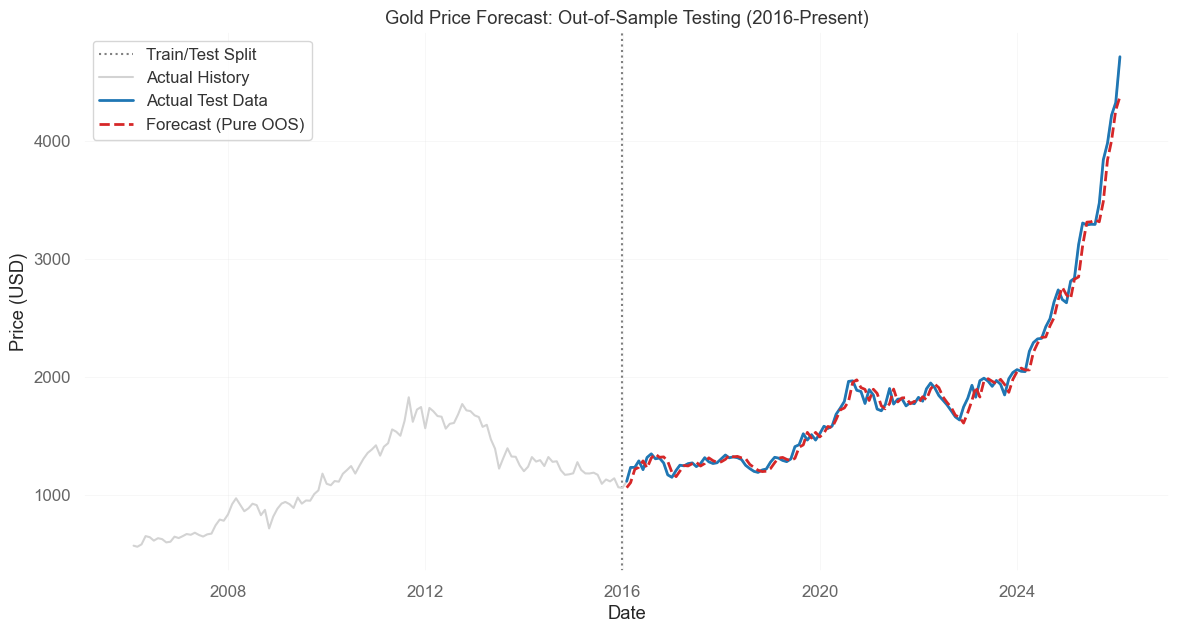

In [32]:
plt.figure(figsize=(14, 7))

plt.axvline(x=pd.to_datetime('2015-12-31'), color='gray', linestyle=':', label='Train/Test Split')

plt.plot(df_ardl.index, np.exp(df_ardl[y_col]), label='Actual History', color='lightgray')
plt.plot(test_data.index, actual_price, label='Actual Test Data', color='#1f77b4', linewidth=2)
plt.plot(test_data.index, pred_price, label='Forecast (Pure OOS)', color='#d62728', linestyle='--', linewidth=2)

plt.title('Gold Price Forecast: Out-of-Sample Testing (2016-Present)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Technical Data

In [33]:
def denoise_data(data, wavelet='db4', level=2):
    coeff = pywt.wavedec(data, wavelet, mode="per")
    sigma = (1/0.6745) * np.median(np.abs(coeff[-1] - np.median(coeff[-1])))
    uthesh = sigma * np.sqrt(2 * np.log(len(data)))
    new_coeff = [coeff[0]]
    for i in coeff[1:]:
        new_coeff.append(pywt.threshold(i, value=uthesh, mode='soft'))
    reconstructed = pywt.waverec(new_coeff, wavelet, mode='per')
    return reconstructed[:len(data)]

In [34]:
macro_feature = results[['Predicted']].copy()
macro_feature.columns = ['Macro_Signal']

# Resample monthly to daily and forward fill
macro_daily = macro_feature.resample('D').asfreq()
macro_daily = macro_daily.ffill()

# Normalize datetime index (remove time component)
macro_daily.index = pd.to_datetime(macro_daily.index.date)
macro_daily

,Macro_Signal
2016-01-31,6.967974
2016-02-01,6.967974
2016-02-02,6.967974
2016-02-03,6.967974
2016-02-04,6.967974
...,...
2026-01-29,8.357185
2026-01-30,8.357185
2026-01-31,8.384016
2026-02-01,8.384016


In [35]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]

# Normalize datetime index (remove time component)
df_daily.index = pd.to_datetime(df_daily.index.date)

df_daily['actual_close'] = df_daily['close'].copy()
df_daily['ln_close'] = np.log(df_daily['close'])

for col in ['open', 'high', 'low', 'close']:
    df_daily[col] = denoise_data(df_daily[col].values)

# Momentum & Trend
df_daily.ta.rsi(length=14, append=True)
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True)
df_daily.ta.adx(length=14, append=True)
df_daily.ta.cci(length=20, append=True)

# Volatility & Bands
df_daily.ta.bbands(length=20, std=2, append=True)
df_daily.ta.atr(length=14, append=True)

# Moving Average Distances
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']

# Statistical & Others
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']
rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

cols_to_drop = ['EMA_50', 'EMA_200', 'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0']
df_daily.drop(columns=[c for c in cols_to_drop if c in df_daily.columns], inplace=True)
df_daily.dropna(inplace=True)
df_daily

,open,high,low,close,volume,actual_close,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,DMP_14,DMN_14,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score
2006-10-17,590.204470,592.309480,586.468188,588.004651,14,589.700012,6.379614,8.986733,-6.402138,0.586069,...,8.694665,21.762750,-52.489688,3.382650,0.250696,4.312874,-0.028313,-0.025856,0.009897,-0.971965
2006-10-18,590.428753,592.107271,587.275108,588.776774,18,588.900024,6.378256,14.883958,-6.049307,0.751120,...,8.004774,20.035952,-40.883658,3.097427,0.306981,4.349966,-0.026005,-0.024338,0.008184,-0.752526
2006-10-19,590.739230,591.881702,587.885553,589.701432,103,599.000000,6.395262,21.448127,-5.630172,0.936204,...,7.476441,18.713535,-29.378781,2.802161,0.376617,4.324693,-0.023538,-0.022584,0.006765,-0.481035
2006-10-20,590.990468,591.066774,588.490627,590.917586,4,593.000000,6.385194,29.183714,-5.140613,1.140610,...,7.148867,17.893618,-18.880856,2.522533,0.473645,4.199797,-0.020697,-0.020368,0.004359,-0.102750
2006-10-23,591.715386,591.376804,589.593221,592.189806,4,579.700012,6.362511,36.255626,-4.596986,1.347390,...,7.472601,17.327562,3.732675,2.270539,0.589057,4.027210,-0.017873,-0.018080,0.003014,0.347209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-12,5013.759701,5052.572887,4893.497562,4917.576221,484,4923.700195,8.501816,55.526905,112.293419,-16.771882,...,26.544209,26.763580,19.122195,14.296728,0.514447,167.754925,0.062326,0.246247,0.031728,0.056323
2026-02-13,4948.753051,5032.829313,4918.728675,4978.590813,232,5022.000000,8.521584,58.048173,108.162317,-16.722388,...,25.211800,25.420159,23.680170,13.330588,0.582013,164.004794,0.072331,0.258432,0.023056,0.319745
2026-02-17,4969.809466,4986.218841,4835.309573,4898.230593,540,4882.899902,8.493495,53.727878,97.282577,-22.081702,...,23.545246,27.393803,-24.523031,12.160020,0.433736,163.069400,0.052751,0.235193,0.030365,-0.258346
2026-02-18,4866.079711,4972.118000,4861.659775,4945.431642,544,4986.500000,8.514490,55.808343,91.415257,-22.359218,...,22.379172,26.037129,-20.737575,11.595519,0.495452,159.311459,0.060281,0.244037,0.022700,-0.017733


In [76]:
df_daily = pd.read_csv('all_gold_data.csv', index_col=0, parse_dates=True)
df_daily.sort_index(inplace=True)
df_daily = df_daily[~df_daily.index.duplicated(keep='first')]

# Normalize datetime index (remove time component)
df_daily.index = pd.to_datetime(df_daily.index.date)

# เก็บ actual_close ไว้เผื่อโค้ดท่อนอื่นๆ ยังต้องเรียกใช้ (ตอนนี้ค่าจะเท่ากับ close ปกติ)
df_daily['actual_close'] = df_daily['close'].copy()
df_daily['ln_close'] = np.log(df_daily['close'])

# df_daily['close'] = df_daily.ta.hma(close=df_daily['actual_close'], length=14)
# df_daily.dropna(subset=['close'], inplace=True)

# Momentum & Trend (คำนวณจากราคา Raw Data ได้เลย ปลอดภัย 100%)
df_daily.ta.rsi(length=14, append=True)
df_daily.ta.macd(fast=12, slow=26, signal=9, append=True)
df_daily.ta.adx(length=14, append=True)
df_daily.ta.cci(length=20, append=True)

# Volatility & Bands
df_daily.ta.bbands(length=20, std=2, append=True)
df_daily.ta.atr(length=14, append=True)

# Moving Average Distances
df_daily.ta.ema(length=50, append=True)
df_daily.ta.ema(length=200, append=True)
df_daily['dist_ema50'] = (df_daily['close'] - df_daily['EMA_50']) / df_daily['EMA_50']
df_daily['dist_ema200'] = (df_daily['close'] - df_daily['EMA_200']) / df_daily['EMA_200']

# Statistical & Others
df_daily['daily_range'] = (df_daily['high'] - df_daily['low']) / df_daily['open']
rolling_mean = df_daily['close'].rolling(window=20).mean()
rolling_std = df_daily['close'].rolling(window=20).std()
df_daily['z_score'] = (df_daily['close'] - rolling_mean) / rolling_std

# Drop columns & Clean NaNs
cols_to_drop = ['EMA_50', 'EMA_200', 'BBU_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0']
df_daily.drop(columns=[c for c in cols_to_drop if c in df_daily.columns], inplace=True)
df_daily.dropna(inplace=True)
df_daily

,open,high,low,close,volume,actual_close,ln_close,RSI_14,MACD_12_26_9,MACDh_12_26_9,...,DMP_14,DMN_14,CCI_20_0.015,BBB_20_2.0,BBP_20_2.0,ATRr_14,dist_ema50,dist_ema200,daily_range,z_score
2006-10-17,598.500000,598.500000,588.500000,589.700012,14,589.700012,6.379614,50.458518,-4.746787,2.615101,...,35.088878,45.829529,51.859694,7.720441,0.620713,8.220058,-0.013457,-0.017311,0.016708,0.470626
2006-10-18,592.500000,594.000000,591.500000,588.900024,18,588.900024,6.378256,49.989510,-3.982560,2.703462,...,33.731548,44.056723,42.555180,7.713823,0.593121,7.940053,-0.014223,-0.018462,0.004219,0.363053
2006-10-19,588.900024,588.900024,588.700012,599.000000,103,599.000000,6.395262,55.600570,-2.532726,3.322637,...,33.666312,46.678896,43.777106,7.976765,0.788178,7.387193,0.002578,-0.001612,0.000340,1.123526
2006-10-20,597.500000,597.500000,597.000000,593.000000,4,593.000000,6.385194,51.876882,-1.846585,3.207022,...,41.751968,45.726591,64.816649,8.032737,0.654731,7.002393,-0.007174,-0.011498,0.000837,0.603253
2006-10-23,579.700012,579.700012,579.700012,579.700012,4,579.700012,6.362511,44.726296,-2.348934,2.163738,...,36.429482,56.479242,-39.048112,8.059421,0.383175,7.452222,-0.028320,-0.033345,0.000000,-0.455467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-12,5060.399902,5078.100098,4892.000000,4923.700195,484,4923.700195,8.501816,53.909634,115.205877,-16.758573,...,31.294211,29.423234,14.940985,16.009600,0.499379,179.118165,0.060485,0.245975,0.036776,-0.002422
2026-02-13,4953.000000,5043.899902,4946.200195,5022.000000,232,5022.000000,8.521584,57.158144,112.721376,-15.394459,...,29.758090,27.978952,26.498372,14.954136,0.604848,174.909704,0.078205,0.267435,0.019725,0.408773
2026-02-17,5020.000000,5020.000000,4847.799805,4882.899902,540,4882.899902,8.493495,51.614386,98.393952,-23.777506,...,27.640521,30.007566,-27.650403,13.449159,0.385602,174.859025,0.046357,0.229487,0.034303,-0.446005
2026-02-18,4872.200195,4987.000000,4869.500000,4986.500000,544,4986.500000,8.514490,55.106788,94.311859,-22.287679,...,26.282004,28.532710,-17.846724,12.905911,0.524872,170.761952,0.065692,0.252388,0.024116,0.096967


In [77]:
"""
For joining daily-marco variable to technical data
"""

macro_to_merge = dollar_index.join(vix, how='inner')
macro_to_merge = macro_to_merge[macro_to_merge.index >= '2016-02-01']
macro_to_merge

,Dollar Index,VIX
2016-02-01,115.3331,0.012586
2016-02-02,115.5530,0.013846
2016-02-03,114.6144,0.013638
2016-02-04,113.6012,0.013758
2016-02-05,114.2935,0.014728
...,...,...
2026-02-09,117.6392,0.010936
2026-02-10,117.5216,0.011207
2026-02-11,117.4601,0.011118
2026-02-12,117.5376,0.013115


In [78]:
df_final = macro_daily.join(df_daily, how='right')
df_final = df_final.join(macro_to_merge, how='left')
df_final = df_final.ffill()
df_final = df_final.dropna()
forecast_horizon = 5
for i in range(1, forecast_horizon + 1):
    col_name = f'target_return_{i}d'
    # df_final[col_name] = np.log(df_final['actual_close']).shift(-i) - np.log(df_final['close'])
    df_final[col_name] = np.log(df_final['close']).shift(-i) - np.log(df_final['close'])

df_predict_latest = df_final.tail(forecast_horizon).copy()

# threshold = 0.00
# choices = [1, 0]
# for i in range(1, forecast_horizon + 1):
#     target_col = f'target_return_{i}d'
#     signal_col = f'signal_{i}d'
    
#     conditions = [
#         (df_final[target_col] >= threshold),
#         (df_final[target_col] < -threshold)
#     ]
    
#     df_final[signal_col] = np.select(conditions, choices, default=0)


df_final.to_csv('gold_technical.csv', index=True)
df_final

,Macro_Signal,open,high,low,close,volume,actual_close,ln_close,RSI_14,MACD_12_26_9,...,dist_ema200,daily_range,z_score,Dollar Index,VIX,target_return_1d,target_return_2d,target_return_3d,target_return_4d,target_return_5d
2016-02-01,6.967974,1116.699951,1130.000000,1115.300049,1127.900024,1682,1127.900024,7.028113,64.166839,10.642216,...,-0.001866,0.013164,1.857178,115.3331,0.012586,-0.000532,0.011810,0.025991,0.026164,0.060213
2016-02-02,6.967974,1128.300049,1131.400024,1123.000000,1127.300049,1230,1127.300049,7.027581,63.809246,11.343690,...,-0.002373,0.007445,1.635960,115.5530,0.013846,0.012343,0.026523,0.026696,0.060745,0.061412
2016-02-03,6.967974,1128.500000,1146.000000,1125.000000,1141.300049,1630,1141.300049,7.039923,68.254895,12.880814,...,0.009915,0.018609,2.148979,114.6144,0.013638,0.014181,0.014354,0.048402,0.049070,0.045727
2016-02-04,6.967974,1142.500000,1157.599976,1141.000000,1157.599976,771,1157.599976,7.054104,72.491743,15.238603,...,0.024091,0.014530,2.432243,113.6012,0.013758,0.000173,0.034221,0.034889,0.031546,0.075113
2016-02-05,6.967974,1155.599976,1174.800049,1146.000000,1157.800049,877,1157.800049,7.054277,72.540188,16.928174,...,0.024021,0.024922,2.035383,114.2935,0.014728,0.034048,0.034716,0.031373,0.074940,0.067864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-12,8.463548,5060.399902,5078.100098,4892.000000,4923.700195,484,4923.700195,8.501816,53.909634,115.205877,...,0.245975,0.036776,-0.002422,117.5376,0.013115,0.019768,-0.008321,0.012674,0.018812,NaN
2026-02-13,8.463548,4953.000000,5043.899902,4946.200195,5022.000000,232,5022.000000,8.521584,57.158144,112.721376,...,0.267435,0.019725,0.408773,117.5258,0.012977,-0.028089,-0.007094,-0.000956,NaN,NaN
2026-02-17,8.463548,5020.000000,5020.000000,4847.799805,4882.899902,540,4882.899902,8.493495,51.614386,98.393952,...,0.229487,0.034303,-0.446005,117.5258,0.012977,0.020995,0.027133,NaN,NaN,NaN
2026-02-18,8.463548,4872.200195,4987.000000,4869.500000,4986.500000,544,4986.500000,8.514490,55.106788,94.311859,...,0.252388,0.024116,0.096967,117.5258,0.012977,0.006138,NaN,NaN,NaN,NaN


In [79]:
df_final.columns

Index(['Macro_Signal', 'open', 'high', 'low', 'close', 'volume',
       'actual_close', 'ln_close', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9', 'ADX_14', 'DMP_14', 'DMN_14', 'CCI_20_0.015',
       'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14', 'dist_ema50', 'dist_ema200',
       'daily_range', 'z_score', 'Dollar Index', 'VIX', 'target_return_1d',
       'target_return_2d', 'target_return_3d', 'target_return_4d',
       'target_return_5d'],
      dtype='object')

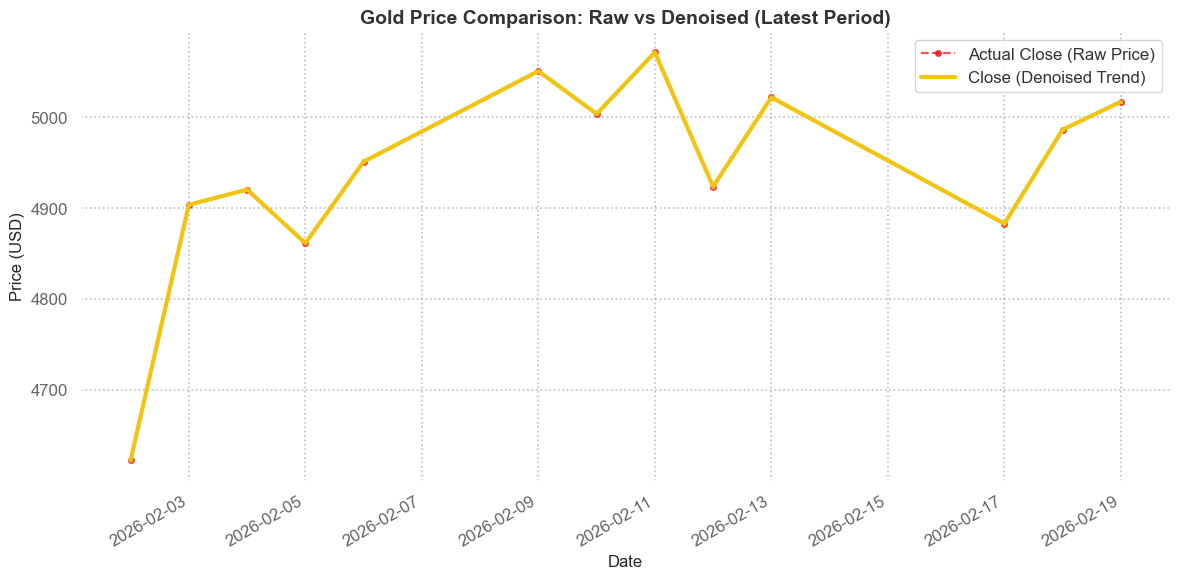

In [ ]:
df = pd.read_csv('gold_technical.csv', index_col=0, parse_dates=True)

subset = df.loc['2025-01-01':].copy() 

plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['actual_close'], 
         label='Actual Close (Raw Price)', 
         color='red', # Red
         linestyle='--', 
         marker='o', 
         markersize=4, 
         alpha=0.7)
plt.plot(subset.index, subset['close'], 
         label='Close (Denoised Trend)', 
         color='#F1C40F', # Gold
         linewidth=3, 
         marker='s', 
         markersize=2)
plt.title(f'Gold Price Comparison: Raw vs Denoised (Latest Period)', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, linestyle=':', alpha=0.5, linewidth=1.2, color='gray')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() 
plt.tight_layout()
plt.show()

## Unique

In [ ]:
# --- ⚙️ Config ---
N_MODELS = 10
WINDOW_SIZE = 10      
BATCH_SIZE = 64       
MODEL_DIR = 'ensemble_huber_models' # 📁 ชื่อโฟลเดอร์ใหม่

os.makedirs(MODEL_DIR, exist_ok=True)

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

print("🚀 Loading Data...")

# --- 1. Data Preparation ---
df = pd.read_csv('gold_technical.csv', index_col=0, parse_dates=True)
df = df[:-5] 

df_train_full = df.dropna(subset=['target_return_5d']).copy()

exclude_cols = ['actual_close', 'close', 'ln_close', 'open', 'high', 'low' ]
# feature_cols = [c for c in df.columns if 'target' not in c and c != 'actual_close' and c != 'close' and c != 'macro_signal']
feature_cols = [c for c in df.columns if 'target' not in c and c not in exclude_cols]
print("Selected Features:", feature_cols)
target_cols = ['target_return_1d', 'target_return_2d', 'target_return_3d', 'target_return_4d', 'target_return_5d']

X = df_train_full[feature_cols].values
y = df_train_full[target_cols].values

train_size = int(len(X) * 0.8)
X_train_raw, X_test_raw = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:(i + window_size)])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, WINDOW_SIZE)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, WINDOW_SIZE)

# --- 2. Multi-Output Ensemble Training ---
print(f"\nTraining Huber Multi-Output Ensemble ({N_MODELS} Models)...")
model_files = []

for i in range(N_MODELS):
    print(f"   Training Model {i+1}/{N_MODELS}...")
    set_seeds(42 + i) # 🌟 สร้างความหลากหลายด้วย Seed ที่ต่างกัน
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=1, padding='same', activation='swish', input_shape=(WINDOW_SIZE, len(feature_cols))),
        MaxPooling1D(pool_size=1),
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        # LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        Dense(64, activation='swish'),
        Dense(5) # 🎯 ทายรวดเดียว 5 วันเพื่อรักษาความต่อเนื่องของเทรนด์
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['mae'])
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mse'])
    
    
    filename = os.path.join(MODEL_DIR, f'gold_huber_ens_{i}.keras')
    model_files.append(filename)
    
    callbacks = [
        ModelCheckpoint(filename, save_best_only=True, monitor='val_loss', mode='min', verbose=0),
        EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    ]

    model.fit(
        X_train_seq, y_train_seq,
        epochs=100, 
        batch_size=BATCH_SIZE,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=callbacks,
        verbose=0
    )

print(f"\nAll ensemble models saved in '{MODEL_DIR}/'")

# --- 3. Prediction & CME Calendar ---
print(f"\nGenerating Forecast...")

last_window = df[feature_cols].tail(WINDOW_SIZE).values
last_window_scaled = scaler_X.transform(last_window).reshape(1, WINDOW_SIZE, len(feature_cols))

all_preds = []
for filename in model_files:
    m = tf.keras.models.load_model(filename)
    all_preds.append(m.predict(last_window_scaled, verbose=0)[0])

avg_returns = np.mean(all_preds, axis=0)
current_actual_price = df['actual_close'].iloc[-1]
last_date = df.index[-1]
predicted_prices = [current_actual_price * np.exp(ret) for ret in avg_returns]

# Market Calendar (CME Gold)
market_cal = mcal.get_calendar('NYSE')
valid_days = market_cal.valid_days(start_date=last_date + pd.Timedelta(days=1), 
                                   end_date=last_date + pd.Timedelta(days=15))
next_5_days = valid_days[:5].tz_localize(None)

print("\n" + "="*55)
print(f"Latest Closing Price ({last_date.strftime('%Y-%m-%d')}): {current_actual_price:.2f}")
print(f"Final Ensemble Forecast (Huber 5-Output):")
print("-" * 55)
for i, (price, date) in enumerate(zip(predicted_prices, next_5_days), 1):
    trend = "🟢 UP" if price > current_actual_price else "🔴 DOWN"
    print(f"Day {i} ({date.strftime('%Y-%m-%d')}): {price:.2f}  {trend} ({price - current_actual_price:+.2f})")
print("="*55)

# --- 4. Final Accuracy Evaluation ---
print(f"\nCalculating Final Test RMSE (Compared vs Actual Price)...")
test_preds_all = []
for filename in model_files:
    m = tf.keras.models.load_model(filename)
    test_preds_all.append(m.predict(X_test_seq, verbose=0))

y_pred_avg = np.mean(test_preds_all, axis=0)
test_start_idx = train_size + WINDOW_SIZE

base_prices_hma = df_train_full['close'].iloc[test_start_idx:].values[:len(y_pred_avg)].reshape(-1, 1)

actual_close_all = df_train_full['actual_close'].values

print("\n" + "="*50)
print(f"Accuracy Summary (Final Ensemble vs ACTUAL PRICE)")
print("="*50)
total_rmse = []

for i in range(5):
    pred_p = base_prices_hma * np.exp(y_pred_avg[:len(base_prices_hma), i].reshape(-1, 1))
    target_idx = np.arange(test_start_idx, test_start_idx + len(base_prices_hma)) + (i + 1)
    valid_mask = target_idx < len(actual_close_all)
    true_p_actual = actual_close_all[target_idx[valid_mask]].reshape(-1, 1)
    pred_p_valid = pred_p[valid_mask]
    
    rmse = np.sqrt(mean_squared_error(true_p_actual, pred_p_valid))
    total_rmse.append(rmse)
    print(f"RMSE {i+1}d (vs Actual) : ${rmse:.2f}")

print("-" * 50)
print(f"Combined RMSE (1-5d): ${np.mean(total_rmse):.2f}")
print("="*50)

🚀 Loading Data...
Selected Features: ['Macro_Signal', 'volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'ADX_14', 'DMP_14', 'DMN_14', 'CCI_20_0.015', 'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14', 'dist_ema50', 'dist_ema200', 'daily_range', 'z_score', 'Dollar Index', 'VIX']

Training Huber Multi-Output Ensemble (10 Models)...
   Training Model 1/10...
   Training Model 2/10...
   Training Model 3/10...
   Training Model 4/10...
   Training Model 5/10...
   Training Model 6/10...
   Training Model 7/10...
   Training Model 8/10...
   Training Model 9/10...
   Training Model 10/10...

All ensemble models saved in 'ensemble_huber_models/'

Generating Forecast...

Latest Closing Price (2026-02-11): 5071.60
Final Ensemble Forecast (Huber 5-Output):
-------------------------------------------------------
Day 1 (2026-02-12): 5034.24  🔴 DOWN (-37.36)
Day 2 (2026-02-13): 5086.04  🟢 UP (+14.43)
Day 3 (2026-02-17): 5137.69  🟢 UP (+66.09)
Day 4 (2026-02-18): 5028.49  🔴 DOWN (-43.11)
Da

In [97]:
real_train_start = df_train_full.index[0].date()
real_train_end = df_train_full.index[train_size - 1].date()

real_test_start = df_train_full.index[train_size].date()
real_test_end = df_train_full.index[-1].date()

pred_start = df_train_full.index[train_size + WINDOW_SIZE].date()
pred_end = df_train_full.index[train_size + WINDOW_SIZE + len(y_pred_avg) - 1].date()

print("="*50)
print(f"📚 ACTUAL TRAIN SET : {real_train_start}  ถึง  {real_train_end}")
print(f"📝 ACTUAL TEST SET  : {real_test_start}  ถึง  {real_test_end}")
print(f"🎯 PREDICTION RANGE : {pred_start}  ถึง  {pred_end}")
print("="*50)

📚 ACTUAL TRAIN SET : 2016-02-01  ถึง  2024-02-08
📝 ACTUAL TEST SET  : 2024-02-09  ถึง  2026-02-11
🎯 PREDICTION RANGE : 2024-02-26  ถึง  2026-02-11


## Evaluation

In [90]:
# --- 1. Setup Test Data ---
# Locate the start of the test set in the original dataframe
test_start_idx = train_size + WINDOW_SIZE
test_df = df_train_full.iloc[test_start_idx:].copy()

# The actual closing price at time T (used as the base to calculate future prices from log returns)
base_prices = test_df['close'].values[:len(y_pred_avg)]

# --- 2. Calculate Historical Volatility (125-day Sigma) ---
# Per rules: Use the Standard Deviation of the closing price for the past 125 trading days
df_full_prices = df['actual_close']
sigma_125d_rolling = df_full_prices.rolling(window=125).std()

# Align sigma values with the test set timeframe
test_sigmas = sigma_125d_rolling.iloc[test_start_idx : test_start_idx + len(y_pred_avg)].values

# --- 3. Convert Returns to Prices & Calculate VAAE ---
vaae_results = []

for i in range(5): # Loop through Day 1 to Day 5 horizons
    # Realized Price (Actual) vs Predicted Price
    # Formula: Base Price * exp(return)
    actual_p = base_prices * np.exp(y_test_seq[:len(base_prices), i])
    pred_p = base_prices * np.exp(y_pred_avg[:len(base_prices), i])
    
    # Absolute Error |Predicted - Actual|
    abs_error = np.abs(pred_p - actual_p)
    
    # VAAE = Absolute Error / Sigma
    # This adjusts the error based on how "noisy" the market was at that time
    vaae_day = abs_error / test_sigmas
    vaae_results.append(vaae_day)

# --- 4. Consolidate into DataFrame ---
vaae_cols = [f'VAAE_{i+1}d' for i in range(5)]
vaae_df = pd.DataFrame(
    np.column_stack(vaae_results), 
    columns=vaae_cols, 
    index=test_df.index[:len(y_pred_avg)]
)

# Calculate the Average VAAE across all 5 days (Your Match 3 Score)
vaae_df['Average_VAAE_Match3'] = vaae_df.mean(axis=1)

# --- 5. Summary Report ---
print("="*65)
print("📊 HISTORICAL VAAE PERFORMANCE REPORT (TEST SET)")
print("="*65)
summary = vaae_df[vaae_cols].mean()
for col in vaae_cols:
    print(f"Mean {col:8} : {summary[col]:.4f}")

print("-" * 65)
overall_score = vaae_df['Average_VAAE_Match3'].mean()
print(f"🏆 OVERALL TEST SET VAAE SCORE: {overall_score:.4f}")
print("   (Lower is better | Goal: < 1.0)")
print("="*65)

# Display latest samples
print("\n🔍 Latest Test Set VAAE Samples:")
print(vaae_df.tail(10))
vaae_df

📊 HISTORICAL VAAE PERFORMANCE REPORT (TEST SET)
Mean VAAE_1d  : 0.1937
Mean VAAE_2d  : 0.2647
Mean VAAE_3d  : 0.3302
Mean VAAE_4d  : 0.4262
Mean VAAE_5d  : 0.4479
-----------------------------------------------------------------
🏆 OVERALL TEST SET VAAE SCORE: 0.3325
   (Lower is better | Goal: < 1.0)

🔍 Latest Test Set VAAE Samples:
             VAAE_1d   VAAE_2d   VAAE_3d   VAAE_4d   VAAE_5d  \
2026-01-29  1.223636  1.446485  0.916683  0.793808  0.975414   
2026-01-30  0.112579  0.512134  0.466478  0.476953  0.551161   
2026-02-02  0.690835  0.713922  0.508108  0.854074  0.961864   
2026-02-03  0.087080  0.074082  0.074113  0.432548  0.196869   
2026-02-04  0.080763  0.091340  0.267106  0.292271  0.292902   
2026-02-05  0.242336  0.421165  0.311467  0.576893  0.084092   
2026-02-06  0.260659  0.092696  0.244714  0.075600  0.074096   
2026-02-09  0.048061  0.008301  0.324368  0.091597  0.438690   
2026-02-10  0.211931  0.208852  0.010439  0.127146  0.125779   
2026-02-11  0.266173  0.1

,VAAE_1d,VAAE_2d,VAAE_3d,VAAE_4d,VAAE_5d,Average_VAAE_Match3
2024-02-26,0.094847,0.090848,0.292583,1.018304,1.515140,0.602344
2024-02-27,0.000272,0.210298,0.881121,1.438233,1.685479,0.843081
2024-02-28,0.231079,0.888186,1.394884,1.720066,1.963938,1.239631
2024-02-29,0.673363,1.155131,1.427413,1.746124,1.852695,1.370945
2024-03-01,0.496746,0.744802,1.044367,1.211447,1.518195,1.003111
...,...,...,...,...,...,...
2026-02-05,0.242336,0.421165,0.311467,0.576893,0.084092,0.327191
2026-02-06,0.260659,0.092696,0.244714,0.075600,0.074096,0.149553
2026-02-09,0.048061,0.008301,0.324368,0.091597,0.438690,0.182203
2026-02-10,0.211931,0.208852,0.010439,0.127146,0.125779,0.136829


## Plot

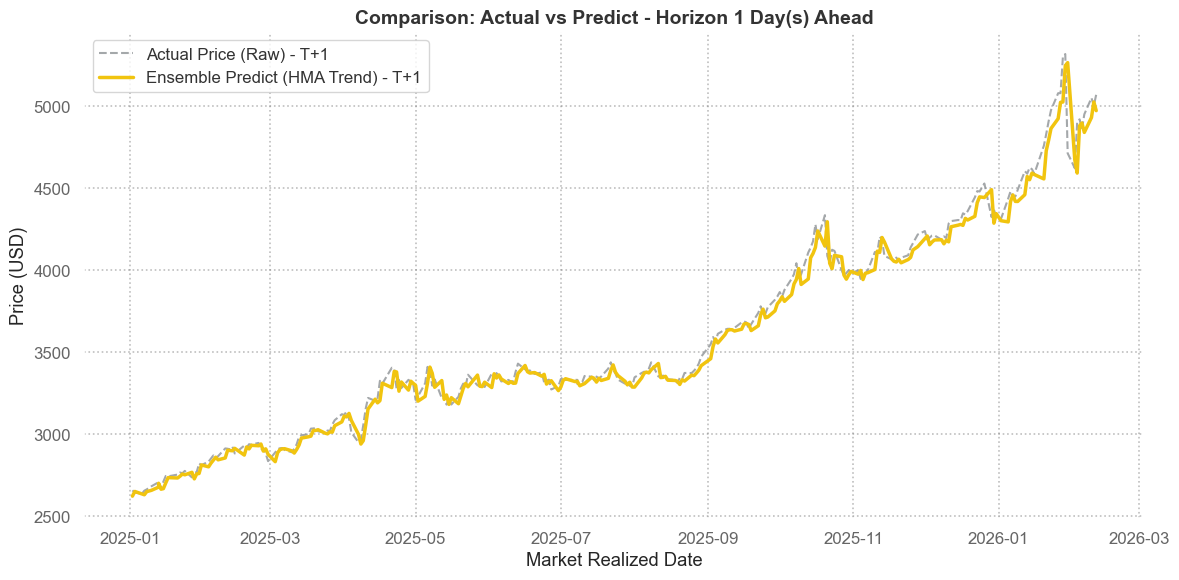

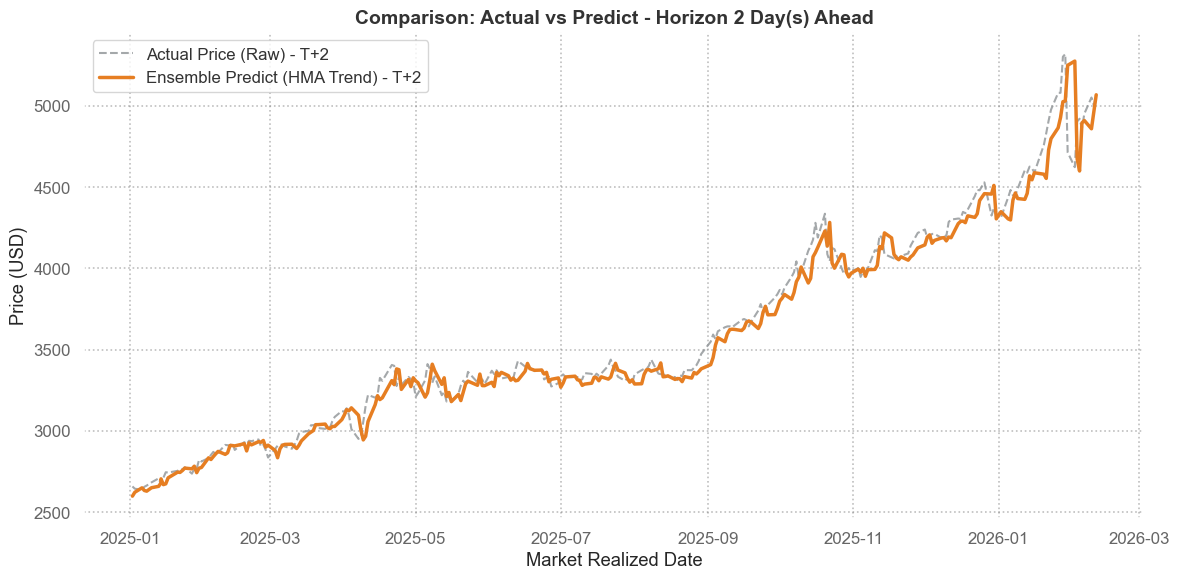

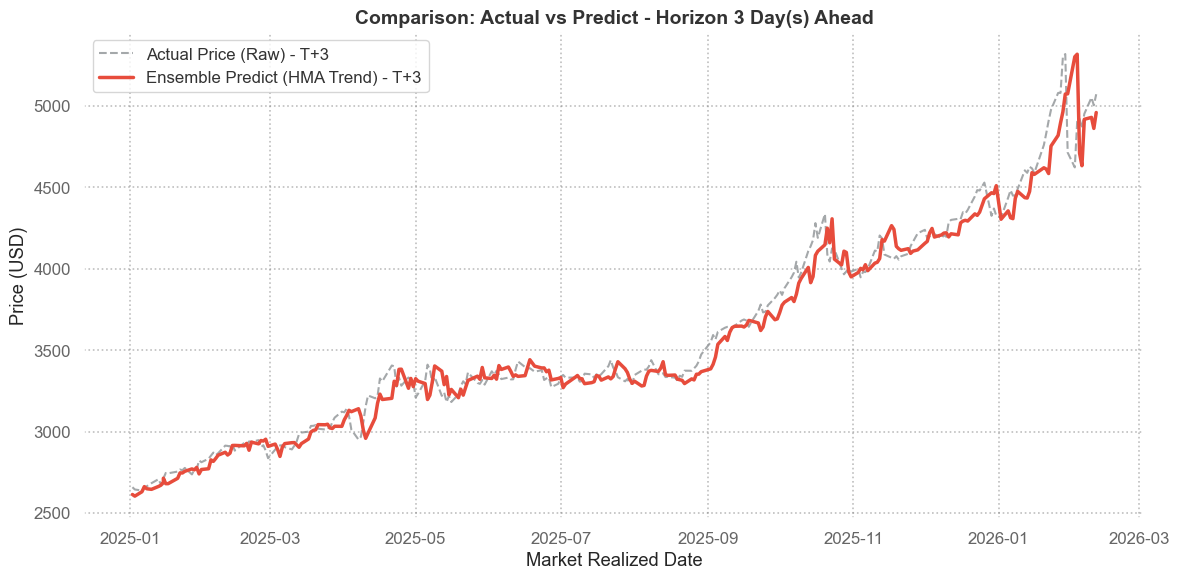

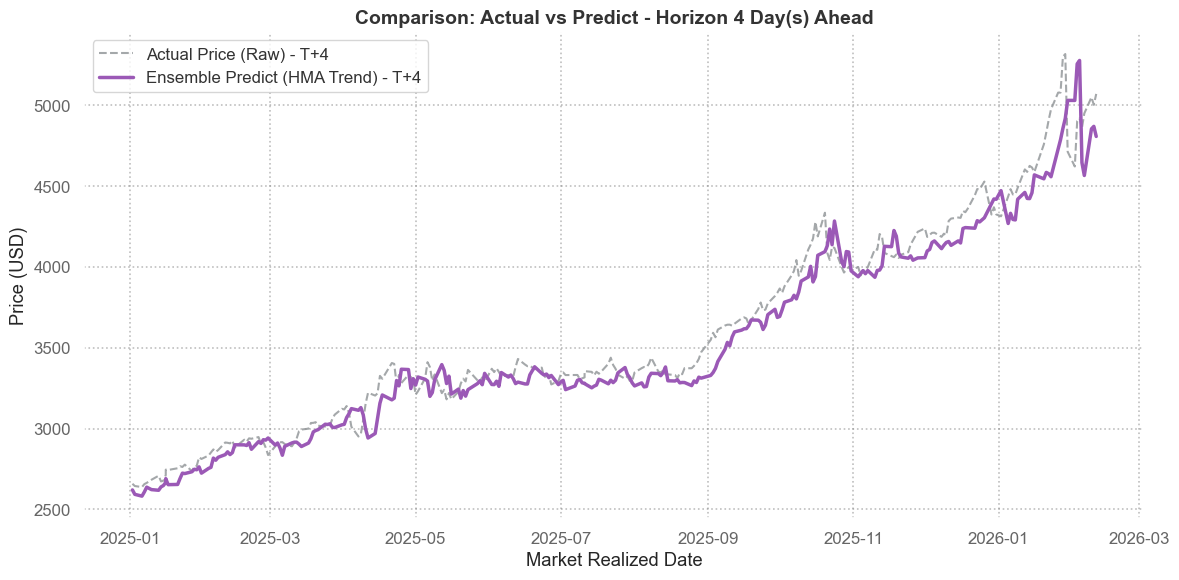

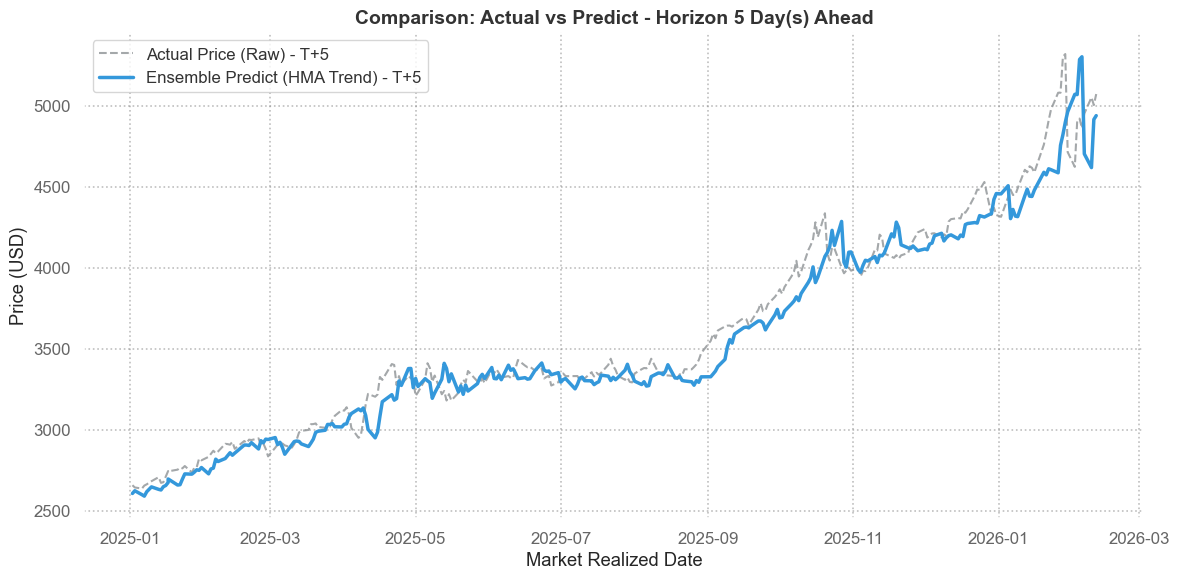

In [95]:
# 1. เตรียมปฏิทิน
cme = mcal.get_calendar('NYSE')
all_trading_days = cme.valid_days(start_date=df_train_full.index.min(), 
                                  end_date=df_train_full.index.max() + pd.Timedelta(days=15))
all_trading_days = all_trading_days.tz_localize(None)

colors_actual = "#8E9295"
colors_pred = ['#F1C40F', '#E67E22', '#E74C3C', '#9B59B6', '#3498DB']

# วันที่ T (ปัจจุบัน) ของชุด Test
test_dates = df_train_full.index[test_start_idx : test_start_idx + len(base_prices_hma)]

for i in range(5):
    plt.figure(figsize=(12, 6))
    
    # ก. ราคาที่พยากรณ์ (จากฐาน HMA)
    pred_p = base_prices_hma * np.exp(y_pred_avg[:len(base_prices_hma), i].reshape(-1, 1))
    
    # ข. ดึงราคาจริงในอนาคต (Actual Price)
    target_idx = np.arange(test_start_idx, test_start_idx + len(base_prices_hma)) + (i + 1)
    valid_mask = target_idx < len(actual_close_all)
    
    true_p_actual = actual_close_all[target_idx[valid_mask]]
    pred_p_valid = pred_p[valid_mask].flatten()
    valid_test_dates = test_dates[valid_mask]
    
    # ค. เลื่อนวันที่ไปข้างหน้า (T+i)
    shifted_dates = []
    for current_date in valid_test_dates:
        idx = np.searchsorted(all_trading_days, current_date)
        shifted_dates.append(all_trading_days[idx + (i + 1)])
    
    # จัดลง DataFrame เพื่อกรองเฉพาะปี 2025 เป็นต้นไป
    df_plot = pd.DataFrame({
        'Date': shifted_dates,
        'Actual': true_p_actual,
        'Predict': pred_p_valid
    })
    df_plot = df_plot[df_plot['Date'] >= '2025-01-01']
    
    # ง. พล็อตกราฟ
    plt.plot(df_plot['Date'], df_plot['Actual'], 
             label=f'Actual Price (Raw) - T+{i+1}', color=colors_actual, linestyle='--', alpha=0.8)
    
    plt.plot(df_plot['Date'], df_plot['Predict'], 
             label=f'Ensemble Predict (HMA Trend) - T+{i+1}', color=colors_pred[i], linewidth=2.5)
    
    plt.title(f'Comparison: Actual vs Predict - Horizon {i+1} Day(s) Ahead', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.5, linewidth=1.2, color='gray')
    plt.ylabel('Price (USD)')
    plt.xlabel('Market Realized Date')
    
    plt.tight_layout()
    plt.savefig(f'actual_vs_predict_T_plus_{i+1}d.png', dpi=300)
    plt.show()

🚀 Loading Data...

Training Huber Multi-Output Ensemble (10 Models)...
   Training Model 1/10...
   Training Model 2/10...
   Training Model 3/10...
   Training Model 4/10...
   Training Model 5/10...
   Training Model 6/10...
   Training Model 7/10...
   Training Model 8/10...
   Training Model 9/10...
   Training Model 10/10...

All ensemble models saved in 'ensemble_huber_models/'

Generating Forecast...

Latest Closing Price (2026-02-11): 5071.60
Final Ensemble Forecast (Huber 5-Output):
-------------------------------------------------------
Day 1 (2026-02-12): 5047.24  🔴 DOWN (-24.36)
Day 2 (2026-02-13): 5052.58  🔴 DOWN (-19.02)
Day 3 (2026-02-16): 5110.20  🟢 UP (+38.60)
Day 4 (2026-02-17): 5056.57  🔴 DOWN (-15.03)
Day 5 (2026-02-18): 5053.21  🔴 DOWN (-18.39)

Calculating Final Test RMSE...

Accuracy Summary (Final Ensemble)
RMSE 1d : $48.79
RMSE 2d : $67.18
RMSE 3d : $75.38
RMSE 4d : $86.06
RMSE 5d : $95.13
--------------------------------------------------
Combined RMSE (1-5d):